In [1]:
from IPython.display import HTML, Image
import matplotlib.pyplot as plt
import torch
import sys  
import os
sys.path.insert(0, '../../..')

from dynnn.simulation.mve_ensemble import MveEnsembleMechanics
from dynnn.simulation.mve_ensemble.viz import visualize_trajectory, plot_energy
from dynnn.simulation.mve_ensemble.mve_ensemble import energy_conservation_loss, calc_kinetic_energy, get_initial_conditions
from dynnn.train import train


In [2]:
import argparse

def get_args():
    parser = argparse.ArgumentParser(allow_abbrev=False)
    parser.add_argument('--device', default="mps", type=str, help="device to run on")
    parser.add_argument('--batch_size', default=1000, type=int, help='batch size')
    parser.add_argument('--hidden_dim', default=300, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=1e-5, type=float, help='weight decay')
    parser.add_argument('--total_steps', default=5000, type=int, help='number of gradient steps')
    parser.add_argument('--n_bodies', default=3, type=int, help='number of particles')
    parser.add_argument('--n_dims', default=3, type=int, help='number of dimensions')
    parser.add_argument('--field_type', default='both', type=str, help='type of vector field to learn (if Hamiltonian)') # solenoidal, conservative, port
    parser.set_defaults(feature=True)
    return parser.parse_known_args()[0]

args = get_args()

torch.set_default_device(args.device)

In [3]:
mechanics = MveEnsembleMechanics()


In [4]:
def plot_energy_from_coords(r, v, time, masses):
    pe = mechanics.no_bc_potential_fn(r).detach().cpu()
    ke = calc_kinetic_energy(v, masses).detach().cpu()
    te = pe + ke

    plot_energy(pe, ke, te, time.cpu())

In [5]:
y0, masses = get_initial_conditions(args.n_bodies, args.n_dims)

# r, v, dr, dv, time = mechanics.get_trajectory({ "y0": y0, "masses": masses }).dict().values()
# plot_energy_from_coords(r, v, time, masses)
# ani = visualize_trajectory(r.detach().cpu(), len(time), mechanics.domain)
# HTML(ani.to_jshtml())


In [6]:
# ani.save(sys.path[0] + '/../images/mve_ensemble.gif', writer='pillow')
# Image(filename=sys.path[0] + '/../images/mve_ensemble.gif')

In [7]:
# load data
import os, pickle
pickle_path = 'mve_ensemble_data.pkl'

if os.path.exists(pickle_path):
    print(f"Loading data from {pickle_path}")
    with open(pickle_path, 'rb') as file:
        data = pickle.loads(file.read())
else:
    print("Creating data...")
    data = mechanics.get_dataset({}, { "y0": y0, "masses": masses })
    print(f"Saving data to {pickle_path}")
    with open(pickle_path, 'wb') as file:
        pickle.dump(data, file)

Loading data from mve_ensemble_data.pkl


In [8]:
# check data
# data_r, data_v = [v.squeeze(-2) for v in torch.split(data["x"][0], 1, dim=-2)]
# plot_energy_from_coords(data_r, data_v, data["time"], masses)
# ani = visualize_trajectory(data_r, len(data["time"]), mechanics.domain)
# HTML(ani.to_jshtml())

In [9]:
# train model
from functools import partial
args.additional_loss = partial(energy_conservation_loss, masses=masses)

model, stats = train(args, data)

step 0, train_loss 2.2848e+01, test_loss 1.5387e+01
step 1, train_loss 2.4567e+01, test_loss 1.4856e+01
step 2, train_loss 2.2488e+01, test_loss 1.3222e+01
step 3, train_loss 1.6082e+01, test_loss 1.4227e+01
step 4, train_loss 2.0210e+01, test_loss 1.4605e+01
step 5, train_loss 2.1762e+01, test_loss 1.4353e+01
step 6, train_loss 2.0776e+01, test_loss 1.3554e+01
step 7, train_loss 1.7574e+01, test_loss 1.3521e+01
step 8, train_loss 1.7405e+01, test_loss 1.3843e+01
step 9, train_loss 1.8689e+01, test_loss 1.3511e+01
step 10, train_loss 1.7400e+01, test_loss 1.2897e+01
step 11, train_loss 1.5000e+01, test_loss 1.3201e+01
step 12, train_loss 1.6279e+01, test_loss 1.3326e+01
step 13, train_loss 1.6807e+01, test_loss 1.3033e+01
step 14, train_loss 1.5638e+01, test_loss 1.2713e+01
step 15, train_loss 1.4325e+01, test_loss 1.2776e+01
step 16, train_loss 1.4519e+01, test_loss 1.2929e+01
step 17, train_loss 1.5090e+01, test_loss 1.2840e+01
step 18, train_loss 1.4734e+01, test_loss 1.2645e+01
ste

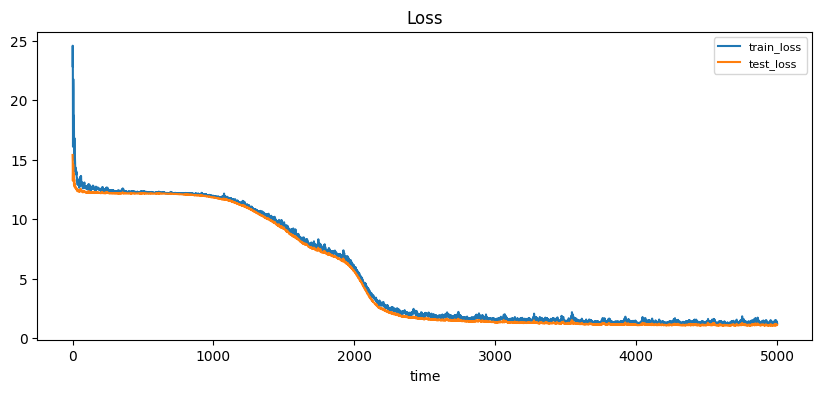

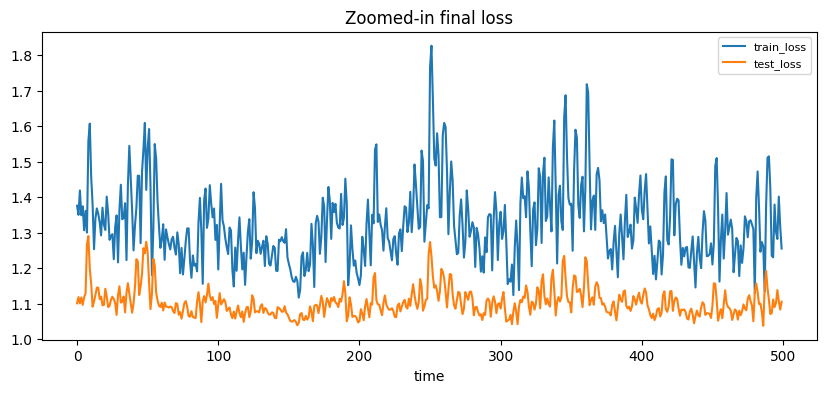

In [10]:
fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title("Loss")
plt.xlabel("time")
plt.plot(stats["train_loss"], label="train_loss")
plt.plot(stats["test_loss"], label="test_loss")
plt.legend(fontsize=8)

fig_e, ax_e = plt.subplots(figsize=[10, 4], dpi=100)
plt.title("Zoomed-in final loss")
plt.xlabel("time")
plt.plot(stats["train_loss"][-500:], label="train_loss")
plt.plot(stats["test_loss"][-500:], label="test_loss")
plt.legend(fontsize=8)


Trajectory 757c13496e224a7dbd2ff683e3cebb46: 500 steps (last t: tensor([21.0120], device='mps:0', grad_fn=<AddBackward0>))
Trajectory 757c13496e224a7dbd2ff683e3cebb46: 1000 steps (last t: tensor([27.4806], device='mps:0', grad_fn=<AddBackward0>))


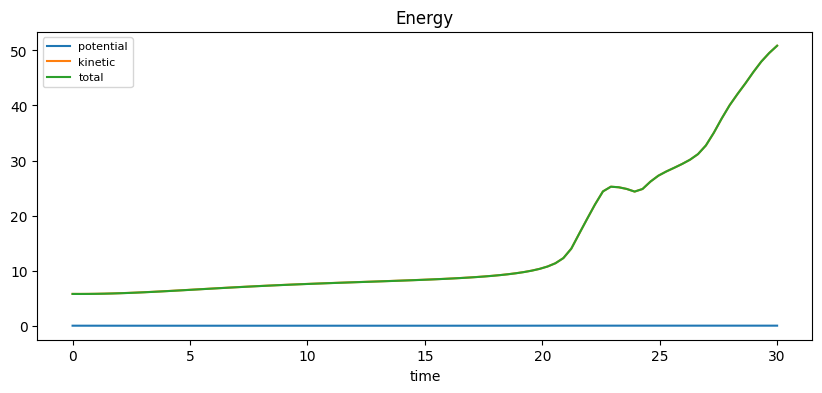

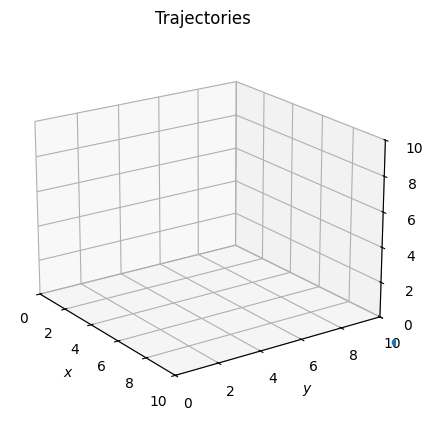

In [11]:
# plot model output

test_y0, test_masses = get_initial_conditions(args.n_bodies, args.n_dims)
initial_state = test_y0.clone().detach().requires_grad_()
r, v, dr, dv, time = mechanics.get_trajectory({"y0": initial_state, "masses": test_masses, "model": model}).dict().values()
plot_energy_from_coords(r, v, time, test_masses)

ani_model = visualize_trajectory(r, len(time), mechanics.domain)
HTML(ani_model.to_jshtml())